In [8]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
import random
%matplotlib inline 

In [3]:
words = open('names.txt', 'r').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [12]:
# build vocabulary of characters 
chars = sorted(list(set(''.join(word for word in words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0 
itos = {i: ch for ch, i in stoi.items()}
print(itos)
vocab_size = len(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
# create the dataset 
def build_dataset(words, block_size):
    # block_size = 3 # how many characters to take to predict the next character 
    X, Y = [], [] 
    for word in words:
        # print(word)
        context = [0] * block_size 
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            # print(''.join(itos[i] for i in context), '------>', itos[ix])    
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8) 
n2 = int(len(words) * 0.9)

block_size = 3 

Xtr, Ytr = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size) # 10%
Xte, Yte = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [18]:
# parameters setting 
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200 
C = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"number of parameters = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True 

number of parameters = 11897


In [19]:
max_steps = 200000
batch_size = 32 
lossi = [] 

for i in range(max_steps):
    
    # mini-batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] 
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb) # logtits as input. 

    # backward pass 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data -= lr * p.grad 
        
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 30.057610
  10000/ 200000: 2.793761
  20000/ 200000: 2.473219
  30000/ 200000: 2.394586
  40000/ 200000: 2.483547
  50000/ 200000: 2.182031
  60000/ 200000: 2.544908
  70000/ 200000: 2.044548
  80000/ 200000: 2.107980
  90000/ 200000: 2.420152
 100000/ 200000: 2.140246
 110000/ 200000: 2.372448
 120000/ 200000: 2.080673
 130000/ 200000: 2.110626
 140000/ 200000: 2.267228
 150000/ 200000: 1.897252
 160000/ 200000: 2.324197
 170000/ 200000: 1.846606
 180000/ 200000: 2.657354
 190000/ 200000: 1.775505


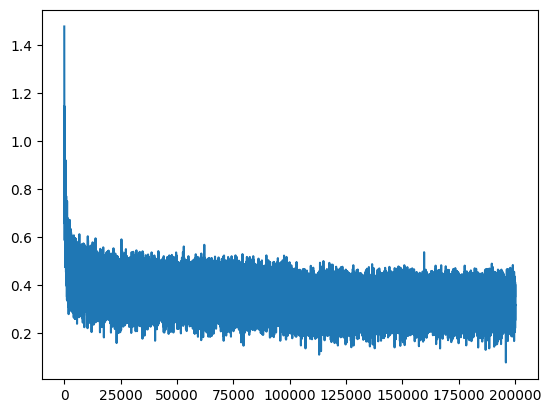

In [20]:
plt.plot(lossi)

In [24]:
@torch.no_grad() 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] 
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [25]:
split_loss('train')
split_loss('val')

train 2.1392390727996826
val 2.179316759109497


In [27]:
# sampling 

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = [] 
    context = [0] * block_size 
    while True:
        emb = C[context] 
        embcat = emb.view(-1, n_embd * block_size)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix] 
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[ix] for ix in out))

dex.
malomonie.
rochitah.
melliston.
inrlenak.
katha.
samiyah.
javer.
gotai.
molie.
caiu.
kented.
jena.
millsede.
enkamirry.
folsp.
huckennatallys.
dasdro.
leenley.
alaisa.
